In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [2]:
basedir = Path().resolve().parent
logdir = basedir / 'logs'
datadir = basedir / 'data'

In [3]:
train = pd.read_csv(datadir / 'train_RC_kfold5_seed42.csv', index_col=0)
train.head()

/home/yamaguchi-milkcocholate/.local/share/virtualenvs/GoogleBrain-VentilatorPressurePrediction-QG-B7qSz/lib/python3.9/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,id,breath_id,R,C,time_step,u_in,u_out,pressure,RC,kfold
0,1,1,20,50,0.000000,0.083334,0,5.837492,20_50,1
1,2,1,20,50,0.033652,18.383041,0,5.907794,20_50,1
2,3,1,20,50,0.067514,22.509278,0,7.876254,20_50,1
3,4,1,20,50,0.101542,22.808822,0,11.742872,20_50,1
4,5,1,20,50,0.135756,25.355850,0,12.234987,20_50,1


In [4]:
def plot(df):
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.plot(df.u_in, label='u_in')
    ax.plot(df.pressure, label='target')
    ax.plot(df.u_out, label='u_out')
    ax.legend()

In [5]:
train_pressure = pd.DataFrame({'breath_id': train.breath_id.unique()})
train_pressure[np.arange(80)] = train.pressure.values.reshape(-1, 80)
train_out = pd.DataFrame({'breath_id': train.breath_id.unique()})
train_out[np.arange(80)] = train.u_out.values.reshape(-1, 80)
train_in = pd.DataFrame({'breath_id': train.breath_id.unique()})
train_in[np.arange(80)] = train.u_in.values.reshape(-1, 80)

In [6]:
def create_mae(save_folder):
    valid_preds = pd.read_csv(logdir / save_folder / 'valid_preds.csv', index_col=0)
    valid_preds['breath_id'] = train_pressure.breath_id.unique()

    records = {'breath_id': train_pressure.breath_id, 'mae': list()}
    for i, (y_true, y_pred, u_out) in enumerate(zip(
        train_pressure.drop('breath_id', axis=1).values, 
        valid_preds.drop('breath_id', axis=1).values,
        train_out.drop('breath_id', axis=1).values,
    )):
        # y_pred = np.clip(y_pred, None, 64.820992)
        mae = ((1 - u_out) * np.abs(y_true - y_pred)).sum()
        mae /= np.sum(1 - u_out)
        records['mae'].append(mae)
    mae_df = pd.DataFrame(records)
    
    return mae_df

In [9]:
mae_dfs = list()
save_folders = ['lstm-addfeatures-last-3', 'lstm-addfeatures-last-2']
for sf in save_folders:
    mae_df = create_mae(sf)
    mae_dfs.append(mae_df)

In [10]:
for mae_df in mae_dfs:
    print(mae_df.mae.mean())

0.20649282277465697
0.20274928678816914


In [14]:
def pick_outers(df):
    m, std = df.mae.mean(), df.mae.std()
    return df[(6 < df.mae)]

In [15]:
outers = list()
for mae_df in mae_dfs:
    outers.append(set(pick_outers(mae_dfs[0]).breath_id))

In [19]:
common_outers = outers[0] & outers[1] & outers[2] & outers[3]

In [20]:
len(common_outers)

3

In [72]:
# train_RC = train.groupby('breath_id')[['R', 'C']].first()
# train_RC = train_RC.reset_index()

In [73]:
# train_RC[train_RC.breath_id.isin(mae_df.sort_values('mae').head(50).breath_id)]

In [74]:
# train_RC[train_RC.breath_id.isin(mae_df.sort_values('mae').tail(50).breath_id)]

In [31]:
mae_df = mae_dfs[2]
save_folder = save_folders[2]
valid_preds = pd.read_csv(logdir / save_folder / 'valid_preds.csv', index_col=0)
valid_preds['breath_id'] = train_pressure.breath_id.unique()

In [32]:
def plot_one(breath_id):
    y_true = train_pressure[train_pressure.breath_id == breath_id].drop('breath_id', axis=1).values.squeeze()
    y_pred = valid_preds[valid_preds.breath_id == breath_id].drop('breath_id', axis=1).values.squeeze()
    
    u_in = train[train.breath_id == breath_id].u_in.values.squeeze()
    u_out = train[train.breath_id == breath_id].u_out.values.squeeze()
    
    _, mae = mae_df[mae_df.breath_id == breath_id].iloc[0]
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.plot(y_true, label='truth')
    ax.plot(y_pred, label='pred')
    ax.plot(u_in, label='u_in')
    ax.plot(u_out, label='u_out')
    ax.legend()
    ax.set_title(f'breath_id={breath_id}, loss={np.round(mae, 5)}')
    fig.show()

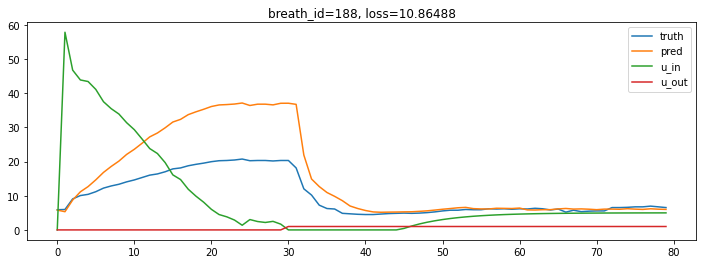

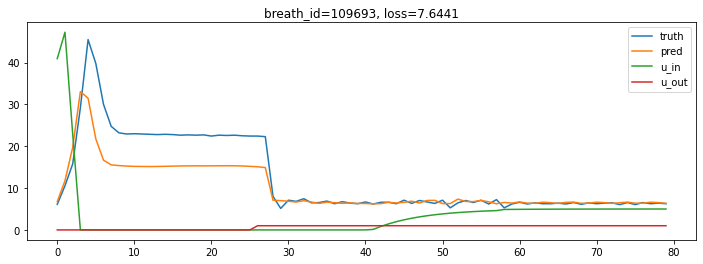

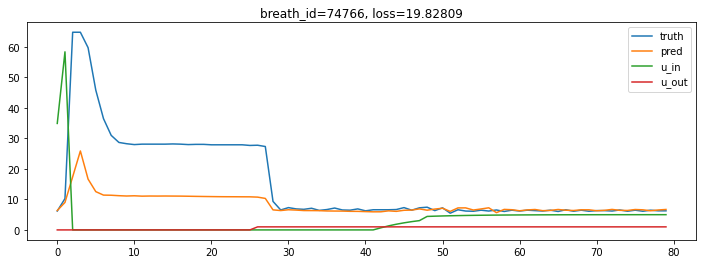

In [33]:
for co in common_outers:
    plot_one(co)

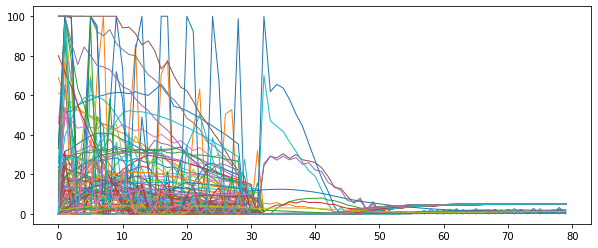

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

u_ins = train_in.drop(['breath_id'], axis=1).values
for y in u_ins[:100, :]:
    ax.plot(y, linewidth=1)

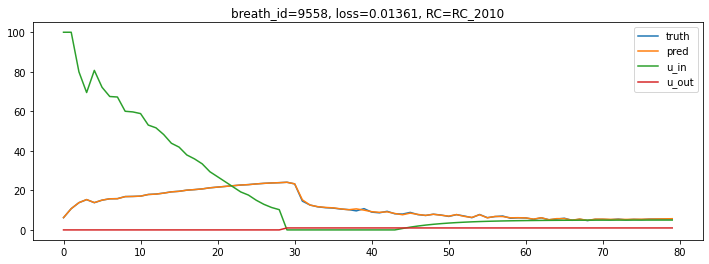

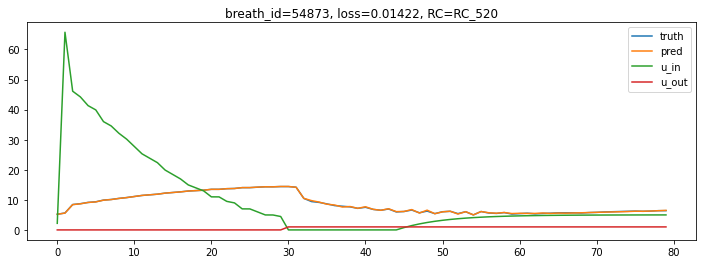

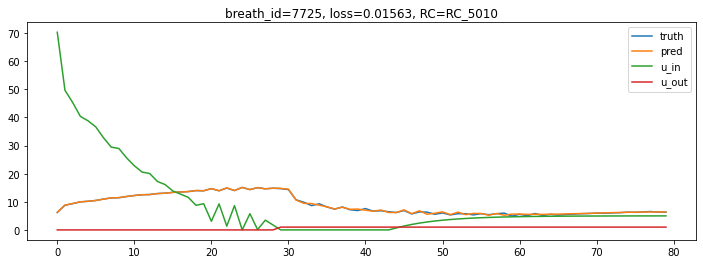

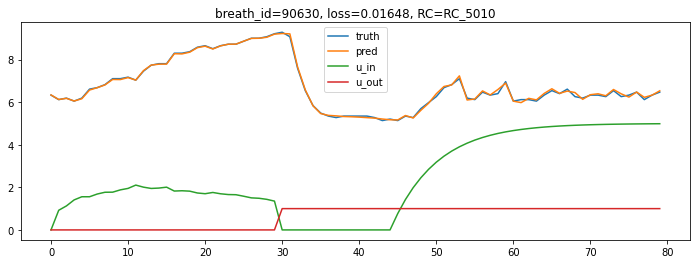

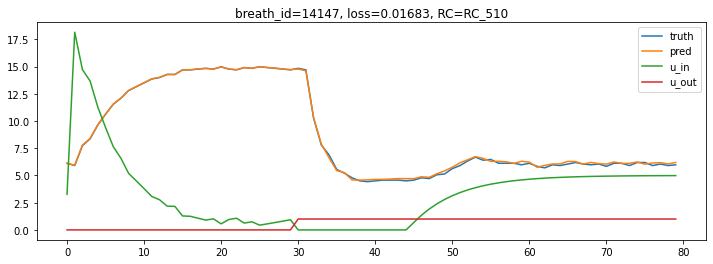

In [17]:
# 良いサンプル
for i in mae_df.sort_values('mae').head(5).breath_id:
    plot_one(i)

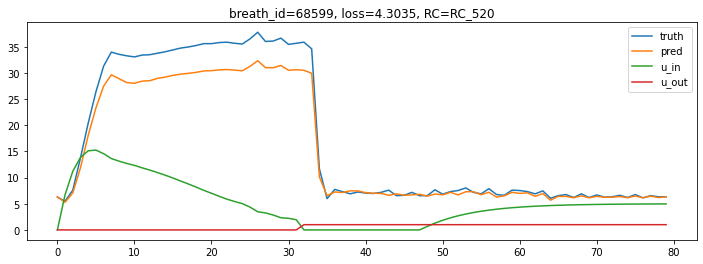

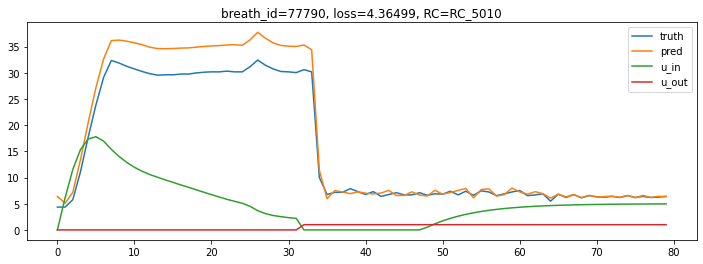

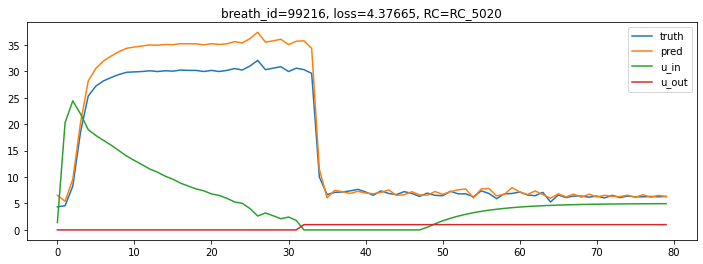

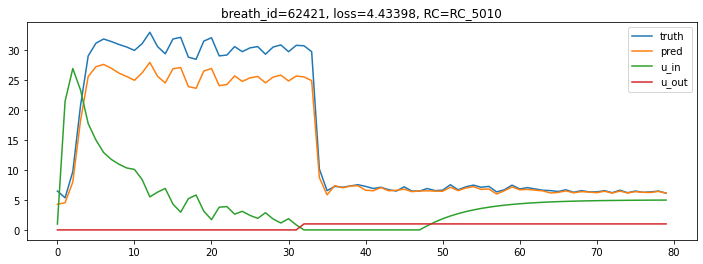

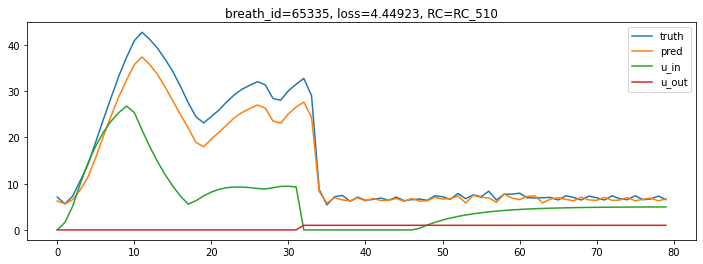

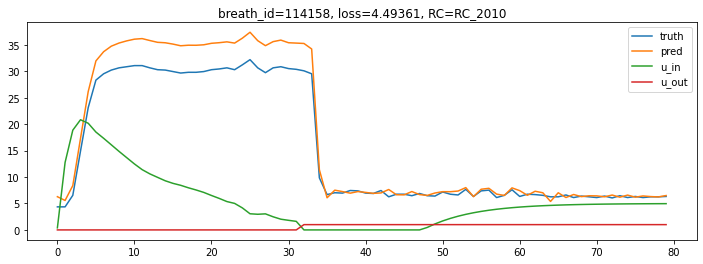

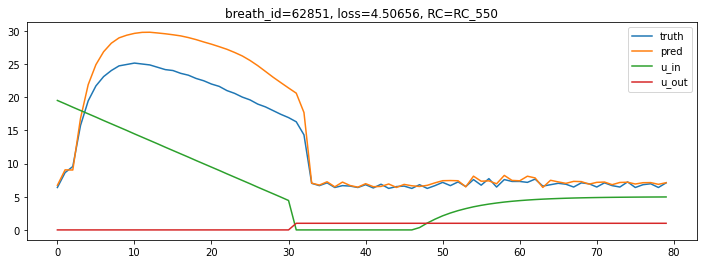

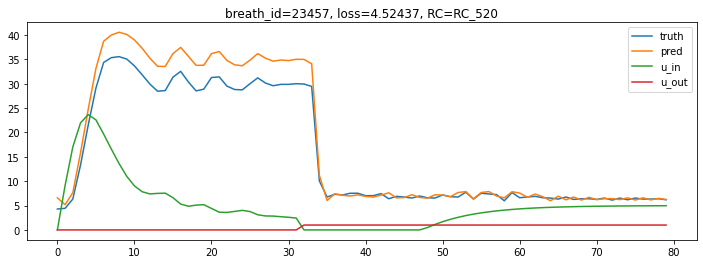

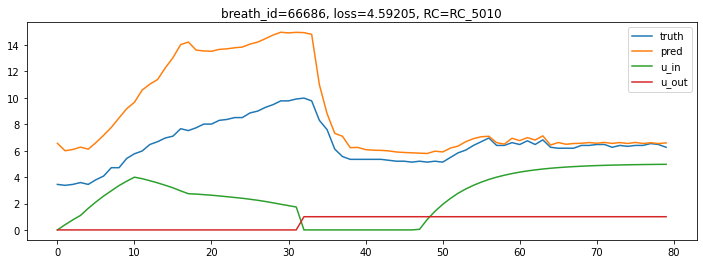

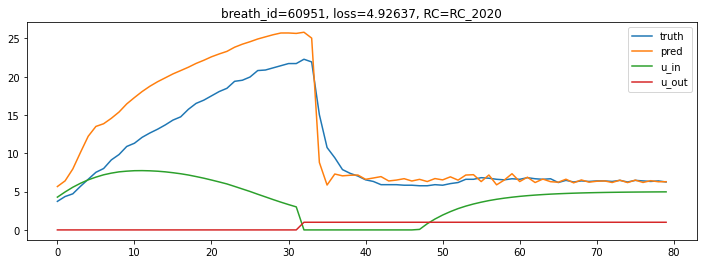

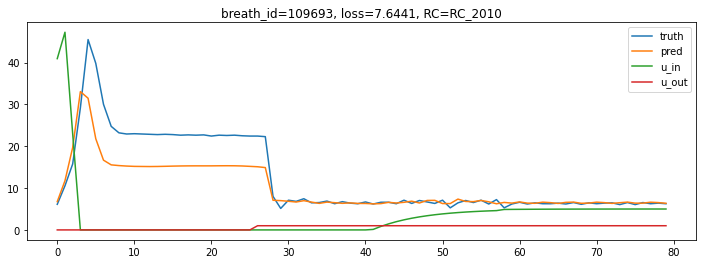

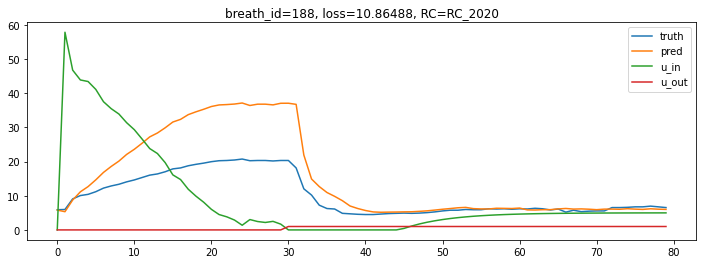

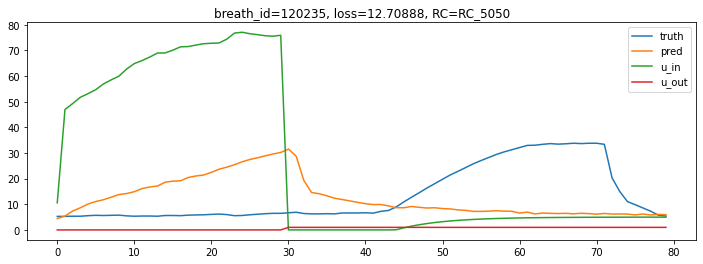

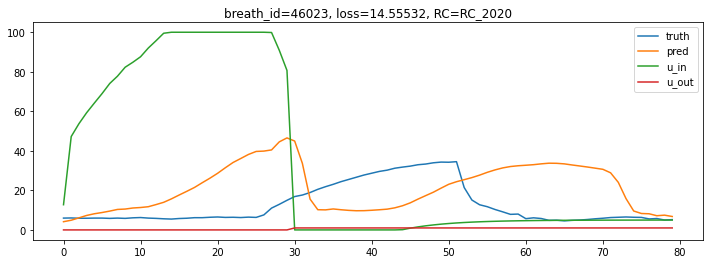

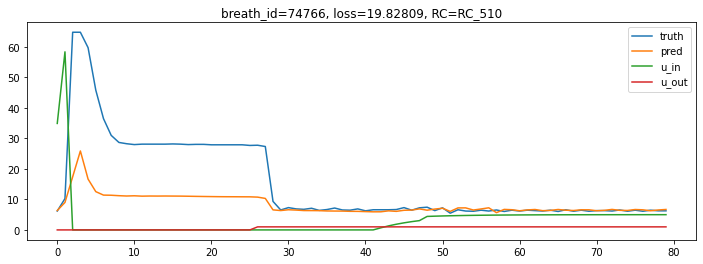

In [18]:
# 悪いサンプル
for i in mae_df.sort_values('mae').tail(15).breath_id:
    plot_one(i)

(array([1.6328e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7923e+04,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8260e+04, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.2803e+04, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.2300e+02, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

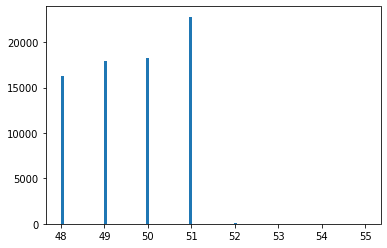

In [99]:
plt.hist(train_out.drop(['breath_id'], axis=1).values.sum(axis=1), bins=100)